# Running EM on the birdsong corpus

## Getting set up

In [24]:
import markhov
import em
import numpy as np
import pandas as pd
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


Read in the birdsong corpus

In [25]:
f=open('../corpus/cath8.txt','r')
corpus = f.readlines()
f.close()
corpus = [line.rstrip('\n') for line in corpus]


Create a transition grammar for the corpus

In [26]:
trans = {'[':[]}
for s in corpus:
    s=['[']+s.split(' ')
    for i in range(1,len(s)):
        trans[s[i-1]]=trans.get(s[i-1],[])
        if s[i] not in trans[s[i-1]]:
            trans[s[i-1]].append(s[i])


Operations FSA

In [27]:
ops = {'S':{'NotCL':['mg']}, # from start we have to merge
       'NotCL':{'NotCL':['mg','copy'], # this state is the state in which the last "special" operation was *not* Clear. 
                #Either we've done none or the last was copy. From here we can do everything including end
               'CLEAR_S':['clear'], # go here to clear the buffer
               'F':['end'] # go here to end
           },
       'CLEAR_S':{'CLEAR':['mg']}, # this is where we've just cleared. Buffer is empty so you can only Merge
       'CLEAR':{'CLEAR':['mg'], # the last special op was Clear so we can Copy or Merge.
                'NotCL':['copy'] # if we Copy, the last special op was Copy so go to NotCL
            },
       'F':{} #final state
   }


## Expectation Maximisation time!

In [28]:
n = 10 # number of EM iterations to do

In [29]:
history=em.em_rabbit(corpus,trans,ops,n) # run EM

### Display the results

Make the rules into a simpler list

In [30]:
rules=[]
for lhs in ops:
    for rhs in ops[lhs]:
        for e in ops[lhs][rhs]:
            rules.append(('%s->%s %s'%(lhs,e,rhs),(lhs,rhs,e)))

Put them and their updating probabilities into a table

In [31]:
tab=[]
for (rule,(lhs,rhs,e)) in rules:
    thisrule={'rule':rule}
    for i in range(n):
        p=history[i]['fsa'][lhs][rhs][e]
        thisrule["p.iteration%i"%i]=p
    tab.append(thisrule)

Use pandas to make the table into a datafram

In [32]:
df = pd.DataFrame(tab)

In [33]:
df

,p.iteration0,p.iteration1,p.iteration2,p.iteration3,p.iteration4,p.iteration5,p.iteration6,p.iteration7,p.iteration8,p.iteration9,rule
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,S->mg NotCL
1,-1.426750,-1.046496,-1.130399,-1.261153,-1.437682,-1.580805,-1.732649,-1.908433,-2.013594,-2.088888,CLEAR->mg CLEAR
2,-0.274553,-0.432579,-0.389943,-0.333136,-0.271123,-0.230432,-0.194575,-0.160536,-0.143302,-0.132189,CLEAR->copy NotCL
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,CLEAR_S->mg CLEAR
4,-1.685695,-2.036312,-2.518721,-3.192208,-3.876223,-4.455800,-4.917870,-5.294980,-5.660672,-6.023689,NotCL->clear CLEAR_S
5,-3.292803,-1.676072,-1.795625,-1.880892,-1.922401,-1.939477,-1.947370,-1.951598,-1.954270,-1.956013,NotCL->end F
6,-0.656128,-0.468702,-0.313466,-0.226857,-0.188213,-0.172058,-0.164379,-0.160002,-0.157231,-0.155472,NotCL->mg NotCL
7,-1.352170,-2.872287,-3.794030,-4.663861,-5.386696,-5.922125,-6.427840,-7.138094,-7.971400,-8.826541,NotCL->copy NotCL


In [34]:
df.to_csv('ops_%s.csv'%('oct_22_2016_aaa')) # print to file

Same for the transitions

In [35]:
bigrams=[]
for lhs in trans:
    for rhs in trans[lhs]:
        bigrams.append(('%s,%s'%(lhs,rhs),(lhs,rhs)))

In [36]:
tab=[]
for (bi,(lhs,rhs)) in bigrams:
    thisrule={'rule':bi}
    for i in range(n):
        p=history[i]['trans_probs'][lhs][rhs]
        thisrule["p.iteration%i"%i]=p
    tab.append(thisrule)

In [37]:
df_bis = pd.DataFrame(tab)

In [38]:
df_bis

,p.iteration0,p.iteration1,p.iteration2,p.iteration3,p.iteration4,p.iteration5,p.iteration6,p.iteration7,p.iteration8,p.iteration9,rule
0,-2.791674,-2.546418,-2.690070,-2.861279,-2.967557,-3.001758,-3.013840,-3.019240,-3.022183,-3.024174,"aua,aiz"
1,-3.743732,-0.599419,-0.660381,-0.806283,-0.898316,-0.926831,-0.936834,-0.941205,-0.943460,-0.945086,"aua,ats"
2,-2.190138,-2.195514,-1.664869,-1.185354,-0.994558,-0.944616,-0.927972,-0.920776,-0.917014,-0.914386,"aua,aua"
3,-2.398029,-2.951883,-3.095536,-3.266744,-3.373022,-3.407223,-3.419305,-3.424705,-3.427648,-3.429639,"aua,amb"
4,-1.738827,-3.645030,-3.788683,-3.959891,-4.066169,-4.100370,-4.112452,-4.117852,-4.120795,-4.122786,"aua,aje"
5,-2.062297,-2.951883,-3.095536,-3.266744,-3.373022,-3.407223,-3.419305,-3.424705,-3.427648,-3.429639,"aua,aiy"
6,-2.615810,-3.645030,-3.788683,-3.959891,-4.066169,-4.100370,-4.112452,-4.117852,-4.120795,-4.122786,"aua,aib"
7,-2.485490,-3.645030,-3.788683,-3.959891,-4.066169,-4.100370,-4.112452,-4.117852,-4.120795,-4.122786,"aua,ban"
8,-2.771008,-3.645030,-3.788683,-3.959891,-4.066169,-4.100370,-4.112452,-4.117852,-4.120795,-4.122786,"aua,awi"
9,-2.621881,-3.645030,-3.788683,-3.959891,-4.066169,-4.100370,-4.112452,-4.117852,-4.120795,-4.122786,"aua,abu"


In [39]:
df_bis.to_csv('trans_%s.csv'%('oct_22_2016_cath8'))

### Calculate the log likelihood of the corpus given the trained grammar

This is the ll of the corpus at the end of training:

In [40]:
# parse the corpus
parsed_corpus=em.parse_corpus(corpus,trans,ops)

In [41]:
em.ll_corpus(parsed_corpus,history[-1]['trans_probs'],history[-1]['fsa'])

-4682.6526573634974

Make a dataframe of the LL of the corpus throughout training:

In [42]:
tab=[]
for i in range(n):
    this_iter={'iteration':i,
               'likelihood':em.ll_corpus(parsed_corpus,history[i]['trans_probs'],history[i]['fsa'])}
    tab.append(this_iter)

In [43]:
df_lls=pd.DataFrame(tab)

In [44]:
df_lls

,iteration,likelihood
0,0,-7271.720251
1,1,-5055.304553
2,2,-4862.774661
3,3,-4760.477633
4,4,-4719.688952
5,5,-4703.513534
6,6,-4694.875355
7,7,-4689.672805
8,8,-4686.593279
9,9,-4684.689459


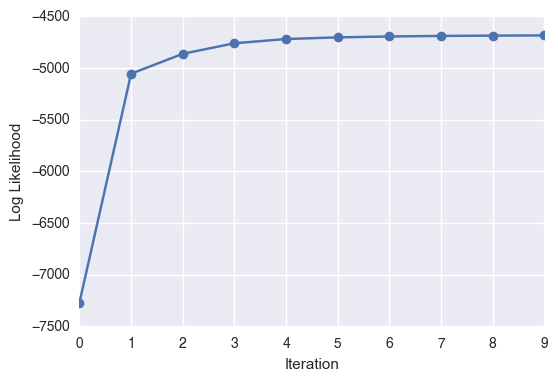

In [45]:
plot(df_lls["iteration"],df_lls["likelihood"],'o-')
xlabel("Iteration")
ylabel("Log Likelihood")